In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
os.chdir("/home/jorge/thesis")

torch.set_grad_enabled(False)

In [2]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.texture_artifact import TextureArtifact
from text3d2video.rendering import render_rgb_uv_map, render_texture
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip
import wandb_util.wandb_util as wbu

tex_tag = "cat_statue_mvlatest_SilverCatStatue:v0"

# read texture
tex_art = TextureArtifact.from_wandb_artifact_tag(tex_tag)
texture = tex_art.read_texture()

# access geometry
texture_run = tex_art.logged_by()
anim = wbu.used_artifacts(texture_run, "animation")[0]
anim = AnimationArtifact.from_wandb_artifact(anim)
cams, meshes = anim.load_frames()
verts_uvs, faces_uvs = anim.uv_data()

# render views
renders = render_texture(meshes, cams, texture, verts_uvs, faces_uvs, return_pil=True)

uvs_vid = pil_frames_to_clip(render_rgb_uv_map(meshes, cams, verts_uvs, faces_uvs))
renders_vid = pil_frames_to_clip(renders)

display_vids([renders_vid, uvs_vid])

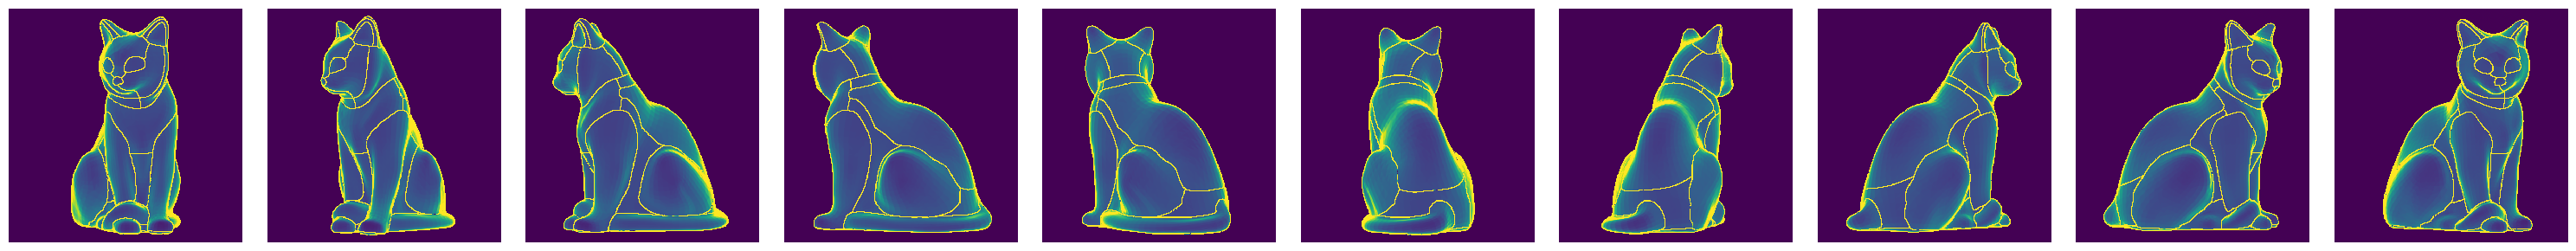

In [3]:
from text3d2video.rendering import compute_uv_jacobian_map
from text3d2video.utilities.ipython_utils import display_ims


quality_maps = [
    compute_uv_jacobian_map(c, m, verts_uvs, faces_uvs) for c, m in zip(cams, meshes)
]
quality_maps = torch.stack(quality_maps)

display_ims(quality_maps, vmin=0, vmax=0.0004)

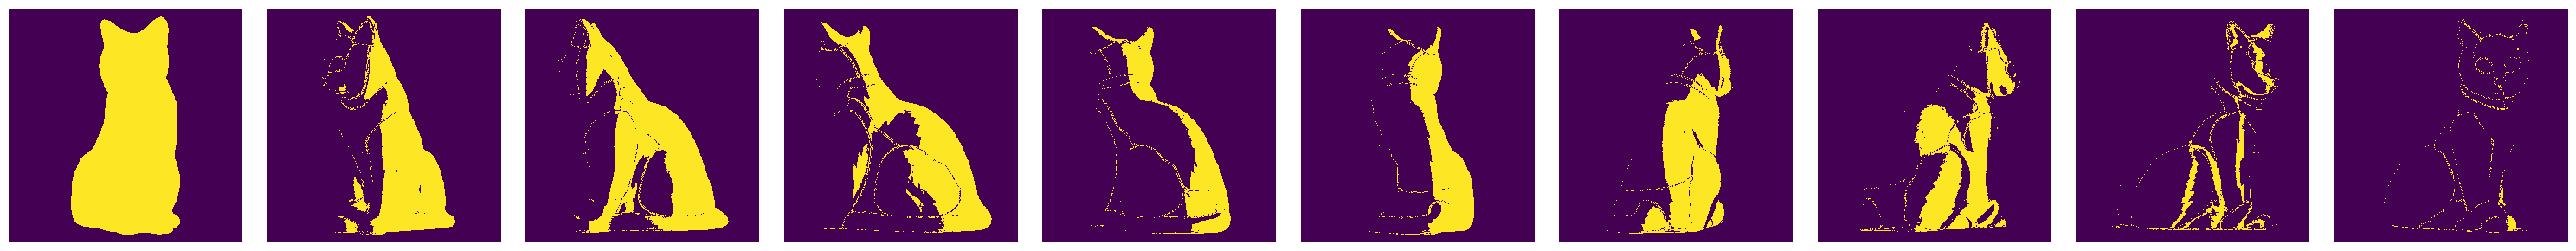

In [5]:
from text3d2video.backprojection import (
    compute_texel_projection,
)
from text3d2video.rendering import compute_autoregressive_update_masks

uv_res = texture.shape[1]
projections = [
    compute_texel_projection(m, c, verts_uvs, faces_uvs, uv_res, raster_res=2000)
    for c, m in zip(cams, meshes)
]

better_quality_masks = compute_autoregressive_update_masks(
    cams,
    meshes,
    projections,
    quality_maps,
    uv_res,
    verts_uvs,
    faces_uvs,
    quality_factor=1.5,
)

display_ims(better_quality_masks)

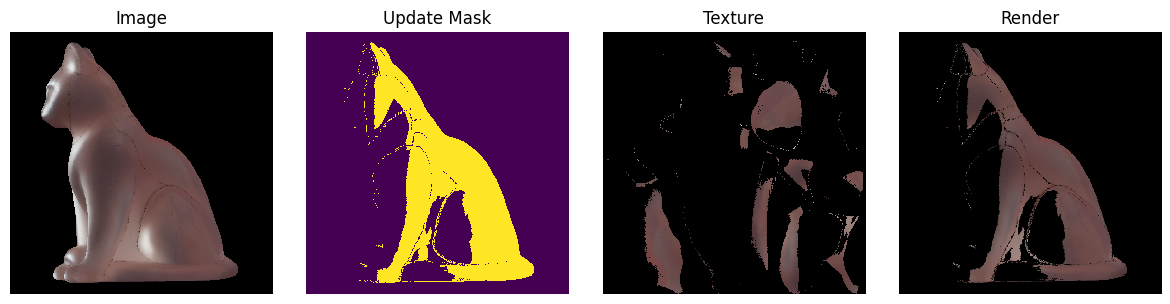

In [28]:
from text3d2video.backprojection import project_view_to_texture_masked
import torchvision.transforms.functional as TF

from text3d2video.util import hwc_to_chw


empty_tex = torch.zeros_like(texture)

view_i = 2
projection = projections[view_i]
mask = better_quality_masks[view_i]
image = renders[view_i]
image_pt = TF.to_tensor(image).cuda()

project_view_to_texture_masked(empty_tex, image_pt, mask, projection)

mesh = meshes[view_i]
cam = cams[view_i]

render = render_texture(mesh, cam, empty_tex, verts_uvs, faces_uvs, return_pil=True)[0]
empty_tex_im = TF.to_pil_image(hwc_to_chw(empty_tex.cpu()))
display_ims(
    [image, mask, empty_tex_im, render],
    titles=["Image", "Update Mask", "Texture", "Render"],
)